In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch
import torchvision
import cv2
import pandas as pd
import glob
import re
import easyocr
import matplotlib.pyplot as plt

In [2]:
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    return dilated

def process_depth_detection(images_folder):
    reader = easyocr.Reader(['en'], gpu=True)
    image_paths = glob.glob(os.path.join(images_folder, '*.jpg'))
    image_paths.sort(key=lambda x: int(re.search(r"_(\d+)\.jpg$", x).group(1)))

    results = []
    pattern = re.compile(r"-00\s*(\d+\.\d+|\d+)")

    for image_path in image_paths:
        frame_number = int(re.search(r"_(\d+)\.jpg$", image_path).group(1))
        img = cv2.imread(image_path)
        if img is None:
            continue

        processed_img = preprocess_image(img)
        ocr_results = reader.readtext(processed_img)
        detected_depth = None
        for _, text, _ in ocr_results:
            match = pattern.search(text)
            if match:
                detected_depth = float(match.group(1))
                if detected_depth >= 21.3:  # Only include depths >= 21.3 meters
                    results.append({
                        'Frame Number': frame_number,
                        'Detected Depth': detected_depth
                    })

    return pd.DataFrame(results)

def apply_depth_consistency_filter(df):
    df = df.sort_values(by='Frame Number')
    df['Depth Difference Prev'] = df['Detected Depth'].diff().abs()
    df['Depth Difference Next'] = df['Detected Depth'].diff(-1).abs()
    consistent_depth_df = df[(df['Depth Difference Prev'] <= 2) | (df['Depth Difference Next'] <= 2)]
    return consistent_depth_df.drop(columns=['Depth Difference Prev', 'Depth Difference Next'])

def marine_growth_plot(txt_folder):
    data = []
    txt_files = sorted(os.listdir(txt_folder))

    for filename in txt_files:
        if filename.endswith(".txt"):
            txt_file = os.path.join(txt_folder, filename)
            frame_number = int(filename.split("_")[-1].split(".")[0])

            with open(txt_file, "r") as file:
                lines = file.readlines()

            for line in lines:
                values = line.strip().split()
                marine_growth = int(values[0])
                confidence = float(values[-1])

                data.append({
                    "Frame Number": frame_number,
                    "Marine Growth": marine_growth,
                    "Confidence": confidence
                })

    return pd.DataFrame(data).sort_values(by="Frame Number")

In [3]:
# Paths
images_folder = r"E:\Priya\Thesis\Depth_identification_2\Frames"
txt_folder = r"E:\Priya\Thesis\Depth_identification_2\Labels"
output_excel_path = r"E:\Priya\Thesis\Depth_identification_2\combined_results_final.xlsx"

In [4]:
# Process data
depth_df = process_depth_detection(images_folder)
marine_df = marine_growth_plot(txt_folder)
consistent_depth_df = apply_depth_consistency_filter(depth_df)
combined_df = pd.merge(consistent_depth_df, marine_df, on="Frame Number", how="left").dropna()
highest_confidence_df = combined_df.loc[combined_df.groupby('Detected Depth')['Confidence'].idxmax()]
highest_confidence_df.to_excel(output_excel_path, index=False)

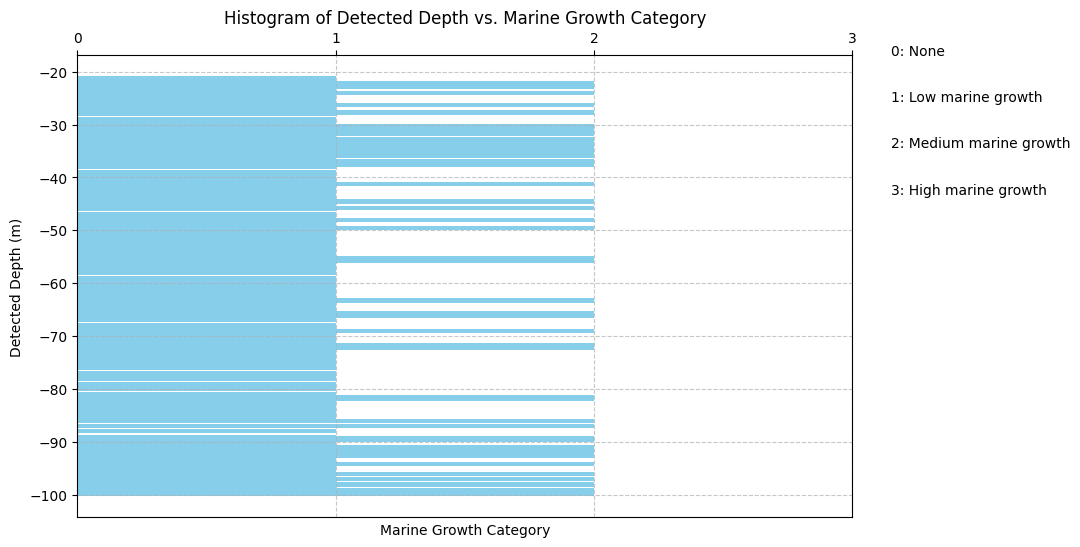

Filtered results with highest confidence have been saved to Excel. Plotting complete.


In [8]:
plt.figure(figsize=(10, 6))
plt.barh(-highest_confidence_df['Detected Depth'], highest_confidence_df['Marine Growth'], color='skyblue')
plt.xlabel('Marine Growth Category')
plt.ylabel('Detected Depth (m)')
plt.title('Histogram of Detected Depth vs. Marine Growth Category')
ax = plt.gca()
ax.xaxis.tick_top()  # Move the x-axis to the top
plt.xticks([0, 1, 2, 3])  # Set x-ticks specifically for categories 0, 1, 2, and 3
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid for better readability

# Create legend without color markers
legend_labels = ['0: None', '1: Low marine growth', '2: Medium marine growth', '3: High marine growth']
for i, label in enumerate(legend_labels):
    plt.text(1.05, 1 - i * 0.1, label, transform=ax.transAxes, fontsize=10)

plt.show()

print("Filtered results with highest confidence have been saved to Excel. Plotting complete.")
